In [52]:
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph
import sympy as sp
import IPython.display as disp
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
import numpy as np
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

In [53]:
def print_matrix(name: str, m: list) -> None:
    disp.display(disp.Math(f"{name}="+sp.latex(sp.Matrix(m))))

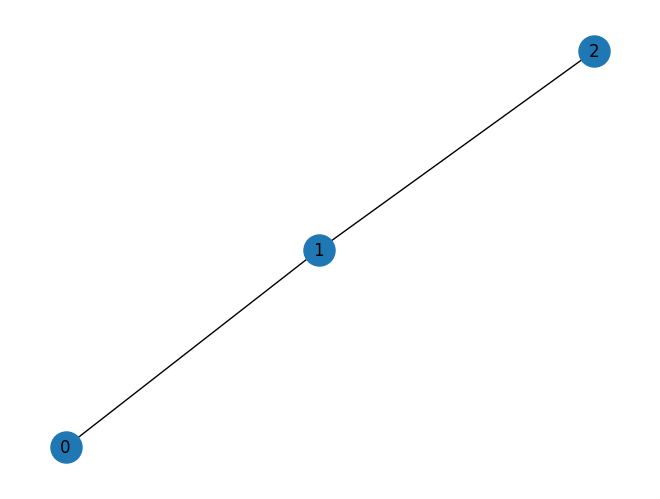

In [54]:
# num_vertices = 5
# graph_edge_list = [
#     (0, 1, 1.0),
#     (0, 2, 1.0),
#     (0, 4, 1.0),
#     (1, 2, 1.0),
#     (2, 3, 1.0),
#     (3, 4, 1.0),
# ]

num_vertices = 3
graph_edge_list = [
    (0, 1, 1.0),
    (1, 2, 1.0),
]

num_edges = len(graph_edge_list)

# t is the maximum possible number of edges in a cut and is assumed to be known upfront
t = 2
 
graph = rx.PyGraph()
graph.add_nodes_from(np.arange(0, num_vertices, 1))

graph.add_edges_from(graph_edge_list)
draw_graph(graph, node_size=500, with_labels=True)

### Circuito para o corte máximo

1. inicialização do circuito

$$
\ket{\varphi_0} = \bigotimes_{d=n}^1 \ket{x_d^0} = \ket{x^0_n\dotso x^0_2x^0_1} = \ket{\underbrace{0\dotso00}_{n\text{ termos}}}
$$

2. aplicação do operador de Hadamard

$$
\ket{\varphi_1}H^{\otimes^n}\ket{\varphi_0} = \frac{\bigotimes_{d=n}^1 (\ket{x_d^0} + \ket{x_d^1})}{\sqrt{2^n}} = \sum_{x=0}^{2^n-1}\frac{\ket{x}}{\sqrt{2^n}}.
$$

Considerações:

1. O estado $\ket{x^0_n\dotso x_1^0}$ em $\ket{\varphi_1}$ codifica a partição de $n$ vértices dos conjuntos $V_1 = \emptyset$ e $V_2=\{v_n, \dotso, v_1\}$.
2. O estado $\ket{x^0_n\dotso x^0_2x_1^1}$ em $\ket{\varphi_1}$ codifica a partição de $n$ vértices dos conjuntos $V_1 = \{v_1\}$ e $V_2=\{v_n, \dotso,v_2\}$.


### Determinando o conjunto do corte para as arestas

Para determinar a qual parte do corte a aresta pertence, introduzimos qubits auxiliares

$$
\ket{r_{j}}, i = 0, 1, \dotso, (2m - 1)
$$

Esses qubits auxiliares tem o propósito de armazenar resultados das operações:

- $x_k\wedge \overline{x_p}$
- $\overline{x_k}\wedge x_p$
- $\overline{x_k}\wedge \overline{x_p}$
- $x_k\wedge x_p$

Além desses qubits precisamos de outros qubits auxiliares

$$
\ket{s_{j}}, j = 0, 1, \dotso, (m-1)
$$

que são inicializados com o valor $1$ e que serão utilizados para avaliar as expressões:

- $s_0 = r_{j_1} \vee r_{j_2}$

### Criação de matrizes $r$ e $z$

In [55]:
r_matrix = [ [0 for j in range(2)] for _ in range(num_edges)]
rij = 0
for i in range(num_edges):
    for j in range(2):
        r_matrix[i][j] = rij
        rij += 1

z_matrix = [ [ 0 for j in range(num_edges + 1) ] for _ in range(num_edges + 1) ]
zij = 0
for i in range(1, num_edges + 1):
    for j in range(i + 1):
        z_matrix[i][j] = zij
        zij += 1

print_matrix("r", r_matrix)
print_matrix("z", z_matrix)

range_z = int((num_edges * (num_edges + 3)) / 2)
range_r = 2 * num_edges
range_s = num_edges

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Construção do subcircuito EIIAC (Edge In-In Assignment Check)

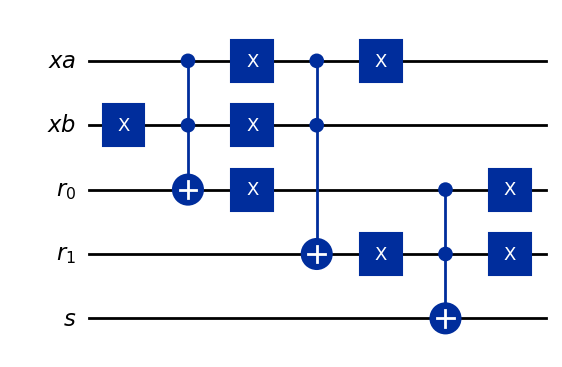

In [56]:
def create_eiiac_subcircuit(init_x: list) -> QuantumCircuit:
    x_a_reg = QuantumRegister(1,'xa')
    x_b_reg = QuantumRegister(1,'xb')
    r_edge_reg = QuantumRegister(2,'r')
    s_edge_reg = QuantumRegister(1,'s')

    eiiac = QuantumCircuit(
        x_a_reg,
        x_b_reg,
        r_edge_reg,
        s_edge_reg,
        name='EIIAC'
    )

    if(init_x[0]):
        eiiac.x(x_a_reg[0])
    if(init_x[1]):
        eiiac.x(x_b_reg[0])

    eiiac.x(x_b_reg[0])
    eiiac.ccx(x_a_reg[0], x_b_reg[0], r_edge_reg[0])
    eiiac.x(x_b_reg[0])
    eiiac.x(x_a_reg[0])
    eiiac.ccx(x_a_reg[0], x_b_reg[0], r_edge_reg[1])
    eiiac.x(x_a_reg[0])
    eiiac.x(r_edge_reg[0])
    eiiac.x(r_edge_reg[1])
    eiiac.ccx(r_edge_reg[0], r_edge_reg[1], s_edge_reg[0])
    eiiac.x(r_edge_reg[0])
    eiiac.x(r_edge_reg[1])

    return eiiac

eiiac = create_eiiac_subcircuit([False, False])

eiiac.draw("mpl")

Vamos analisar o circuito EIIAC

Seja $\ket{sr_1r_0x_bx_a} = \ket{00000}$ termos

$$
\begin{align*}
\ket{sr_1r_0x_bx_a} &= \ket{00000} \\
                    & \to  X_1\ket{00000} = \ket{00010} \\
                    &\to CCX_{0,1,2}\ket{00010} = \ket{00010} \\
                    &\to X_0X_1X_2\ket{00010} = \ket{00101} \\
                    &\to CCX_{0,1,3}\ket{00101} = \ket{00101} \\
                    &\to X_0X_3\ket{00101} = \ket{01100} \\
                    &\to CCX_{2,3,4}\ket{01100} = \ket{11100} \\
                    &\to X_2X_3\ket{11100} = \ket{10000} \\
\end{align*}
$$

a seguir podemos ver a simulação para todos os quatro casos de $x_a$ e $x_b$. Note que o resultado de $s$ está invertido, temos o valor $0$ quando $x_a$ e $x_b$ estão em conjuntos distintos da partição. Esta inversão é resolvida no circuito final, quando inicializamos os registradores $s$ com o valor $\ket{1}$.

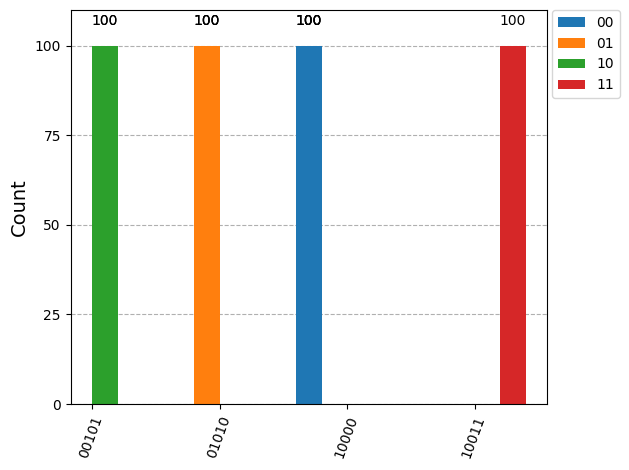

In [57]:
eiiac_sim_00 = create_eiiac_subcircuit([False, False])
eiiac_sim_01 = create_eiiac_subcircuit([False, True])
eiiac_sim_10 = create_eiiac_subcircuit([True, False])
eiiac_sim_11 = create_eiiac_subcircuit([True, True])

eiiac_sim_list = [
    eiiac_sim_00,
    eiiac_sim_01,
    eiiac_sim_10,
    eiiac_sim_11,
]

result_list = []
for eiiac_s in eiiac_sim_list:
    eiiac_s.measure_all()
    sim_eiiac = AerSimulator()
    eiiac_t = transpile(eiiac_s, sim_eiiac)
    result = sim_eiiac.run(eiiac_t, shots=100).result()
    counts = result.get_counts()
    result_list.append(counts)

plot_histogram(result_list, legend=["00", "01", "10", "11"])

### Criação do circuito para o max-cut

Ao criar o circuito para o max-cut, aplicamos a superposição em todos os registradores que representam vértices (registradores $x$) e fazemos $\ket{s_j} = \ket{1}$.

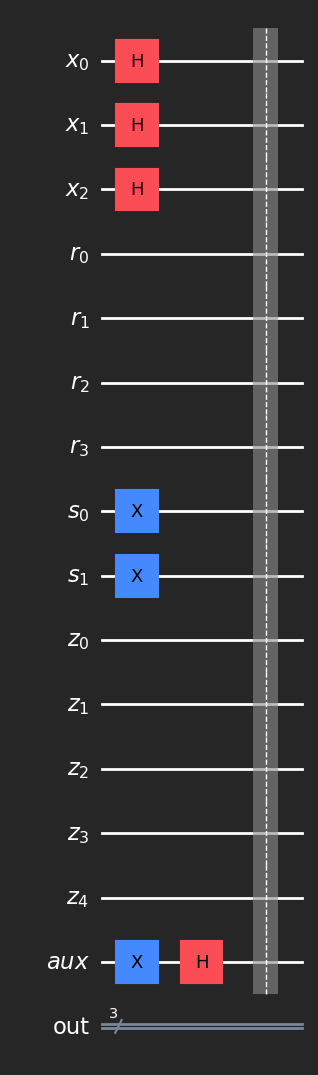

In [60]:
def create_max_cut_circuit(aux, x_reg, r_reg, s_reg, z_reg, readout) -> QuantumCircuit:
    qc = QuantumCircuit(x_reg, r_reg, s_reg, z_reg, aux, readout, name="max_cut")

    for qubit in x_reg:
        qc.h(qubit)

    for qubit in s_reg:
        qc.x(qubit)

    qc.x(aux)
    qc.h(aux)

    qc.barrier()

    return qc

aux = QuantumRegister(1, 'aux')
x_reg = QuantumRegister(num_vertices, 'x')
r_reg = QuantumRegister(range_r, 'r')
s_reg = QuantumRegister(range_s, 's')
z_reg = QuantumRegister(range_z, 'z')
readout = ClassicalRegister(num_vertices, 'out')

qc_ex = create_max_cut_circuit(aux, x_reg, r_reg, s_reg, z_reg, readout)

qc_ex.draw("mpl", style="iqp-dark")

In [61]:
num_solutions = 2
num_runs = int(np.ceil(np.pi * np.sqrt((2**num_vertices) / num_solutions)) / 4)
print('Number of iterations:', num_runs)

Number of iterations: 1


### Circuito de Difusão

3


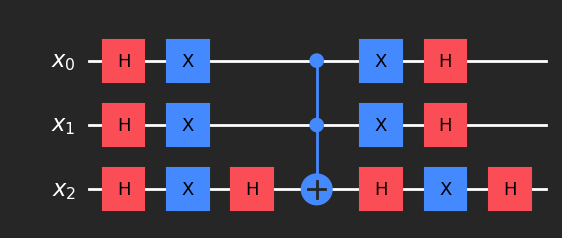

In [62]:
def create_diffusion_circuit(num_vertices: int) -> QuantumCircuit:
    print(num_vertices)
    x_reg = QuantumRegister(num_vertices, "x")
    diff_circ = QuantumCircuit(x_reg, name="Us")

    for i in range(num_vertices):
        diff_circ.h(i)
        diff_circ.x(i)

    last_vertex = num_vertices-1
        
    diff_circ.h(last_vertex)
    multiplexer = list(range(last_vertex))
    diff_circ.mcx(multiplexer, last_vertex)
    diff_circ.h(last_vertex)

    for i in range(num_vertices):
        diff_circ.x(i)
        diff_circ.h(i)

    return diff_circ

diff_circ_ex = create_diffusion_circuit(num_vertices=num_vertices)
diff_circ_ex.draw("mpl", style="iqp-dark")

### Algoritmo para max-cut

3


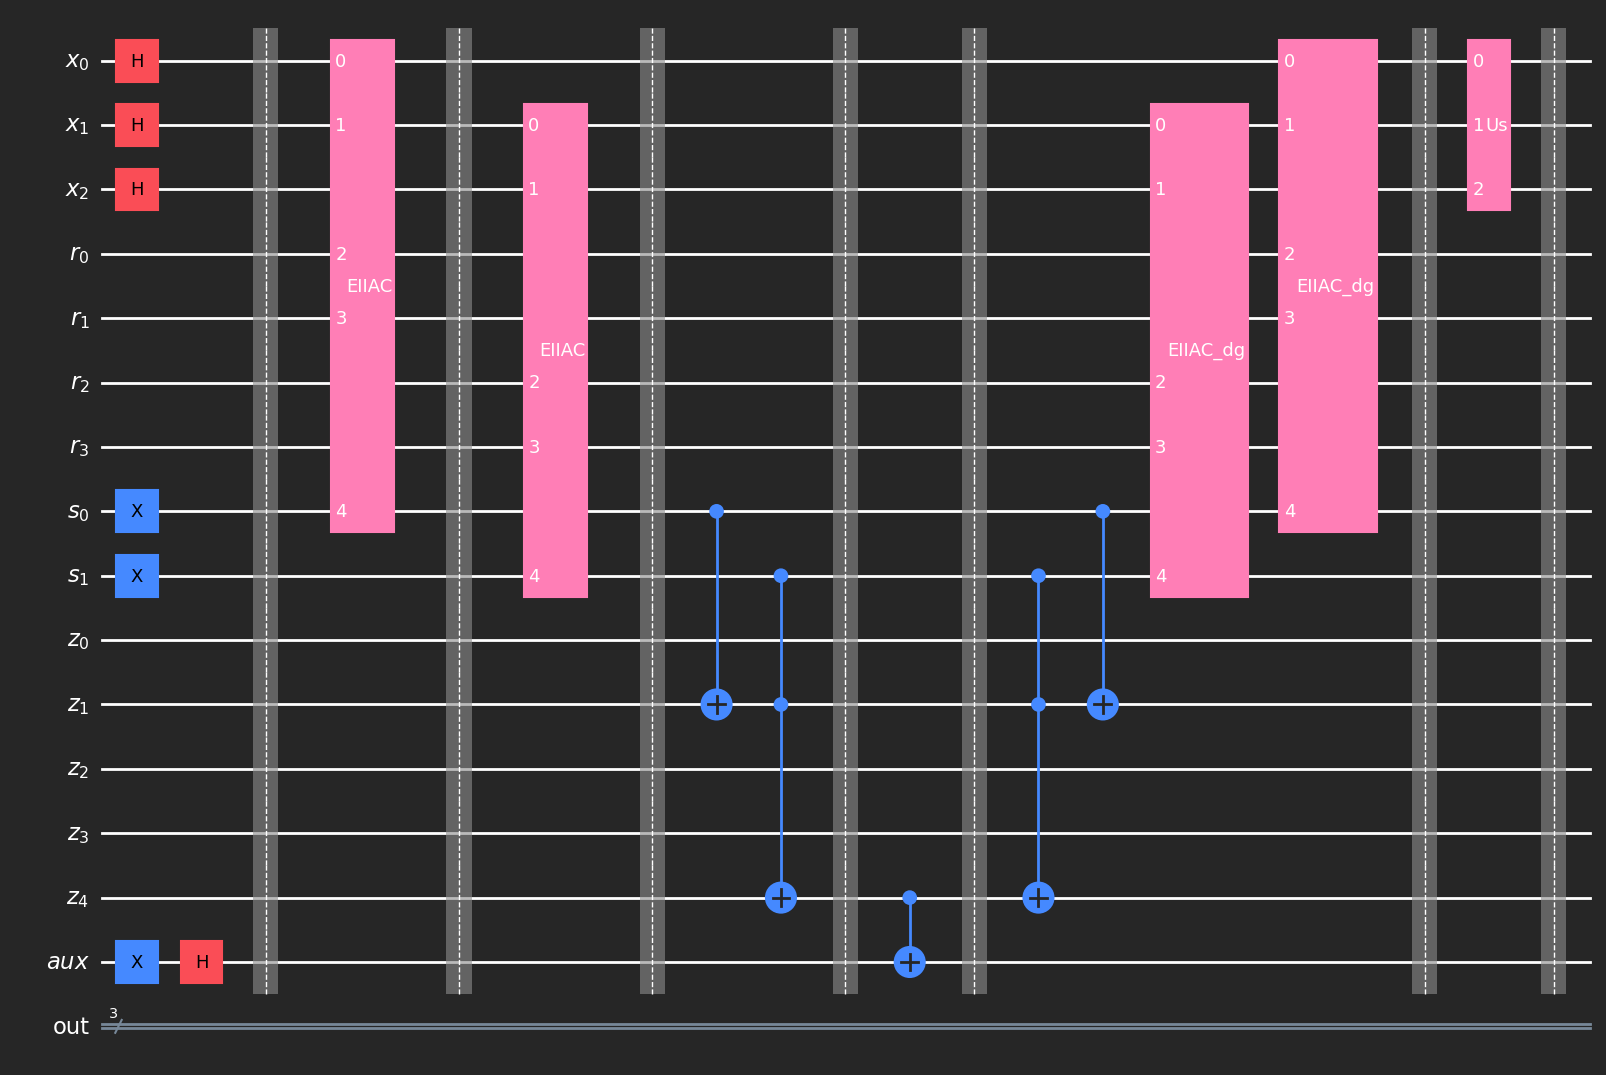

In [63]:
aux = QuantumRegister(1, 'aux')

x_reg = QuantumRegister(num_vertices, 'x')
r_reg = QuantumRegister(range_r, 'r')
s_reg = QuantumRegister(range_s, 's')
z_reg = QuantumRegister(range_z, 'z')
readout = ClassicalRegister(num_vertices, 'out')

qc = create_max_cut_circuit(aux, x_reg, r_reg, s_reg, z_reg, readout)

diff_circ = create_diffusion_circuit(num_vertices)

for run in range(num_runs):
    # Apply EIIAC 
    edge_list = graph_edge_list.copy()
    
    for index, edge in enumerate(edge_list):
        index_v1, index_v2 = edge[0], edge[1]
        cfe_qubits = []
        cfe_qubits += [x_reg[index_v1]]
        cfe_qubits += [x_reg[index_v2]]
        cfe_qubits += [r_reg[k] for k in range(2*index, 2*index+2)]
        cfe_qubits += [s_reg[index]]

        qc.append(eiiac, cfe_qubits)
        qc.barrier()
    
    # Apply INO
    if t > 0:
        qc.cx(s_reg[0], z_reg[1])

    # Apply PNO
    if t < num_edges:
        qc.x(s_reg[0])
        qc.cx(s_reg[0], z_reg[0])
        qc.x(s_reg[0])

    # Apply CIO and CPO
    for i in range(1, num_edges):
        for j in reversed(range(i+1)):
            if j+1 <= t and num_edges-i+j == t:
                qc.ccx(s_reg[i], z_reg[z_matrix[i][j]], z_reg[z_matrix[i+1][j+1]])
            if j <= t and num_edges-i+j-1 == t:
                qc.x(s_reg[i])
                qc.ccx(s_reg[i], z_reg[z_matrix[i][j]], z_reg[z_matrix[i+1][j+1]])
                qc.x(s_reg[i])

    '''
    Which qubit of register z_reg is used here depends on how many edges are there in the cut.
    For the example in Fig. 1 we expect 2 edges, and therefore we choose qubit 2 (counting from 0, 1, 2, etc.).
    This qubit should be in the state 1.
    
    YOU MAY NEED TO ADJUST THE CONTROL QUBIT IN THE CX GATE.
    '''
    
    qc.barrier()
    qc.cx(z_reg[z_matrix[num_edges][t]], aux)
    qc.barrier()

    '''
    Uncomputing CIO, CPO, PNO, INO, and EIIAC, 
    '''
    
    # uncompute CIO and CPO
    for i in range(1, num_edges):
        for j in reversed(range(i+1)):
            if j+1 <= t and num_edges-i+j == t:
                qc.ccx(s_reg[i], z_reg[z_matrix[i][j]], z_reg[z_matrix[i+1][j+1]])
            if j <= t and num_edges-i+j-1 == t:
                qc.x(s_reg[i])
                qc.ccx(s_reg[i], z_reg[z_matrix[i][j]], z_reg[z_matrix[i+1][j+1]])
                qc.x(s_reg[i])
                

    # Uncompute PNO
    if t < num_edges:
        qc.x(s_reg[0])
        qc.cx(s_reg[0], z_reg[0])
        qc.x(s_reg[0])
    
    # Uncompute INO
    if t > 0:
        qc.cx(s_reg[0], z_reg[1])

    # Uncompute EIIAC
    index = len(edge_list) - 1
    for edge in reversed(edge_list):
        index_v1, index_v2 = edge[0], edge[1]
        cfe_qubits = []
        cfe_qubits += [x_reg[index_v1]]
        cfe_qubits += [x_reg[index_v2]]
        cfe_qubits += [r_reg[k] for k in range(2*index, 2*index+2)]
        cfe_qubits += [s_reg[index]]
        index -= 1
        qc.append(eiiac.inverse(), cfe_qubits)
    
    '''
    Diffusion operations
    '''

    qc.barrier()
    qc.append(diff_circ, x_reg)
    qc.barrier()

qc.draw("mpl", fold=-1, style="iqp-dark")

### Medida

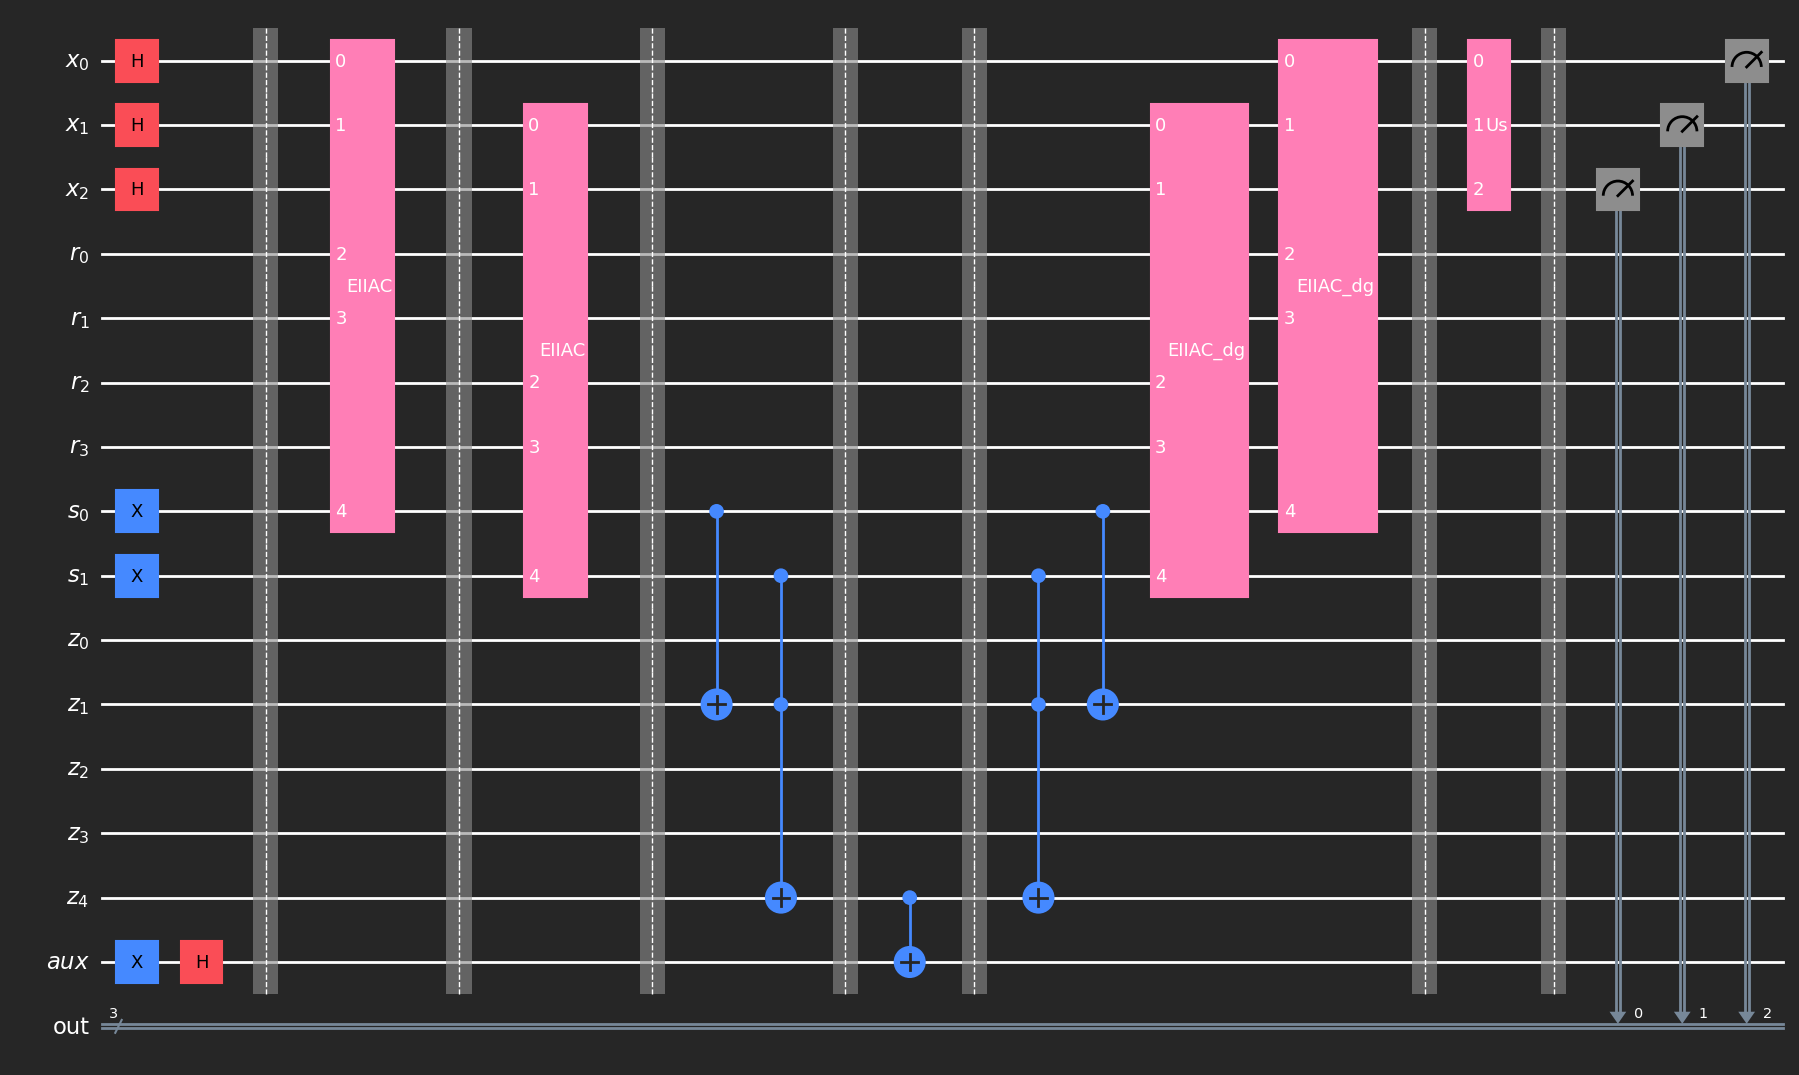

In [64]:
cuts = []
for i in range(len(x_reg)):
    cuts.append(x_reg[i])

# Reverse the order in which the output is shown so that it can be read from left to right.
cuts.reverse()

qc.measure(cuts, readout)

qc.draw("mpl", fold=-1, style="iqp-dark")

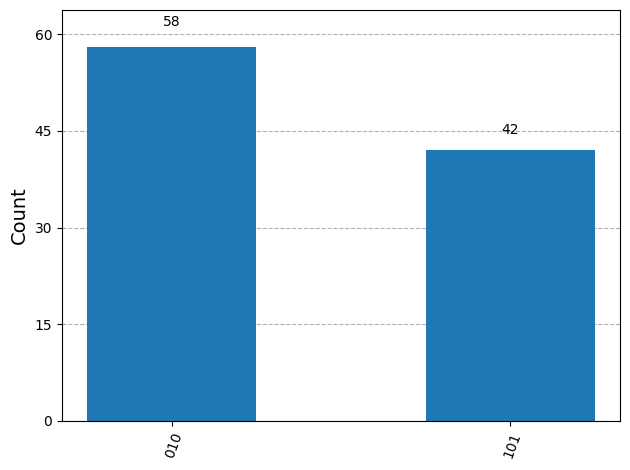

In [65]:
sim = AerSimulator()

qc = transpile(qc, sim)

result = sim.run(qc, shots=100).result()
counts = result.get_counts()

plot_histogram(counts)

## Referências

- [Quantum Speedup for the Maximum Cut Problem](https://arxiv.org/pdf/2305.16644)
- https://github.com/renatawong/quantum-maxcut/blob/5cfe3544b78f365fa78f4d8edba0d7885cbd39e5/quantum_maxcut_algorithm.ipynb
